In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [5]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yadirareyes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yadirareyes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yadirareyes/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yadirareyes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yadirareyes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/yadirareyes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## 1) Data Cleaning
In this section, we will clean the dataset by:

- Removing missing values.
- Removing URLs, emojis, and punctuation.
- Lowercasing all text for consistency.
- Removing duplicates

The goal is to ensure the dataset is clean and ready for further processing.

In [7]:
# Load the dataset
file_path = "cyberbullying_tweets.csv"
df = pd.read_csv(file_path)

#  the first few rows of the dataset
print("Initial Data Overview:")
df.head()

Initial Data Overview:


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [8]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Drop rows with missing values in 'tweet_text' column
df.dropna(subset=['tweet_text'], inplace=True)


Missing Values:
tweet_text            0
cyberbullying_type    0
dtype: int64


In [9]:
# Define emoji removal pattern
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002700-\U000027BF"  # dingbats
    u"\U00002600-\U000026FF"  # misc symbols
    u"\U0001F900-\U0001F9FF"  # supplemental symbols & pictographs
    u"\U0001FA70-\U0001FAFF"  # extended pictographs
    "]+", flags=re.UNICODE)

In [10]:
def preprocess_text(text):
    """
    Preprocesses text by:
    - Lowercasing
    - Removing URLs, emojis, punctuation, and special characters
    - Removing single-character tokens

    Returns:
        str: Cleaned text
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002700-\U000027BF"  # dingbats
        u"\U00002600-\U000026FF"  # misc symbols
        u"\U0001F900-\U0001F9FF"  # supplemental symbols & pictographs
        u"\U0001FA70-\U0001FAFF"  # extended pictographs
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove punctuation and special characters
    text = re.sub(r"’", '', text)  # Handle smart apostrophes
    text = re.sub(r"[^\w\s]", '', text)  # Remove all punctuation except word characters and spaces

    # Remove single-character tokens (except meaningful ones like 'a', 'i')
    text = re.sub(r'\b[b-z]\b', '', text)  # Exclude 'a' and 'i' from removal

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [11]:
# Apply cleaning function
df['cleaned_text'] = df['tweet_text'].apply(preprocess_text)

# Verify cleaned_text contains strings
print(df['cleaned_text'].apply(type).unique())  # Should only show <class 'str'>

[<class 'str'>]


In [12]:
# Check for duplicate tweets
print("\nDuplicate Tweets:")
print(df.duplicated(subset=['cleaned_text']).sum())

# Drop duplicate tweets
df.drop_duplicates(subset=['cleaned_text'], inplace=True)

# Check duplicates again after dropping
print("\nDuplicate Tweets After Dropping:")
print(df.duplicated(subset=['cleaned_text']).sum())


Duplicate Tweets:
2176

Duplicate Tweets After Dropping:
0


## 2) Tokenization and Lemmatization
Here we tokenize the text into words and lemmatize each word to its root form for normalization.

In [14]:
# Define helper functions for tokenization and lemmatization
def get_wordnet_pos(treebank_tag):
    """
    Converts Treebank POS tags to WordNet POS tags.
    """
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

In [15]:
# adding to stopwords: i noticed that some words are not useful for the analysis
custom_stopwords = {'get'}  # Add any other unhelpful tokens
stop_words.update(custom_stopwords)

In [16]:
def tokenize_and_lemmatize(text):
    """
    Tokenizes and lemmatizes cleaned text.

    Returns:
        List[str]: Processed tokens
    """
    tokens = word_tokenize(text)  # Tokenize text
    pos_tags = nltk.pos_tag(tokens)  # Part-of-speech tagging
    lemmatizer = WordNetLemmatizer()  # Initialize lemmatizer
    processed_tokens = [
        lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag))
        for token, tag in pos_tags
        if token not in string.punctuation and token not in stop_words
    ]
    return processed_tokens

In [17]:
# Apply tokenization and lemmatization
df['processed_tokens'] = df['cleaned_text'].apply(tokenize_and_lemmatize)

# Save the processed dataset
df.to_csv('processed_tweets.csv', index=False)

# save into a new df
cleaned_df = pd.read_csv('processed_tweets.csv')

#### Saving and Verifying the Processed Data
Finally, we save the cleaned and tokenized dataset to a new CSV file for further analysis or modeling.

In [19]:
# Display sample processed tokens
print("\nSample Processed Data:")
print(df[['processed_tokens']].head())


Sample Processed Data:
                                    processed_tokens
0       [word, katandandre, food, crapilicious, mkr]
1  [aussietv, white, mkr, theblock, imacelebritya...
2  [xochitlsuckkks, classy, whore, red, velvet, c...
3  [jason_gio, meh, thanks, head, concern, anothe...
4  [rudhoeenglish, isi, account, pretend, kurdish...


## 4) Exploratory Data Analysis (EDA)
In this section we will analyze the class distribution to understand the data better.

In [21]:
print("\nClass Distribution:")
print(df['cyberbullying_type'].value_counts())


Class Distribution:
cyberbullying_type
religion               7965
age                    7934
ethnicity              7909
not_cyberbullying      7852
gender                 7728
other_cyberbullying    6128
Name: count, dtype: int64


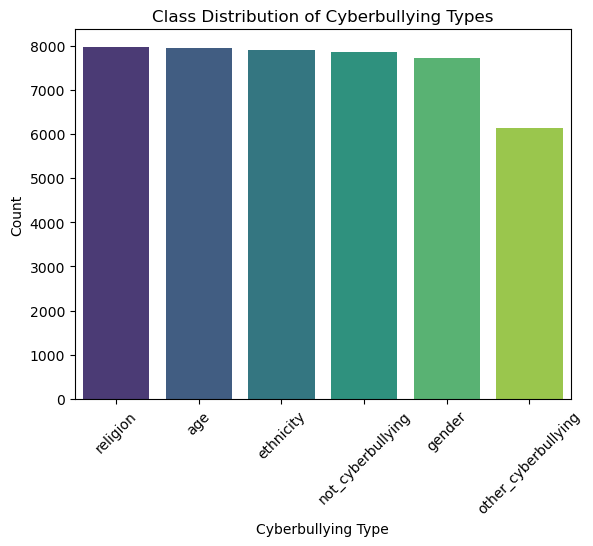

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution bar chart
class_counts = df['cyberbullying_type'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Class Distribution of Cyberbullying Types")
plt.xlabel("Cyberbullying Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [23]:
# Token frequency (flat list of all tokens)
from collections import Counter
all_tokens = [token for tokens in df['processed_tokens'] for token in tokens]
token_counts = Counter(all_tokens).most_common(10)
#print as a table
print("\nToken Frequency:")
print(pd.DataFrame(token_counts, columns=['Token', 'Frequency']))


Token Frequency:
    Token  Frequency
0   bully      10601
1  school       9108
2    fuck       7189
3    like       6134
4  nigger       5567
5    girl       5423
6    joke       5414
7    dumb       5316
8    high       5122
9  people       4809


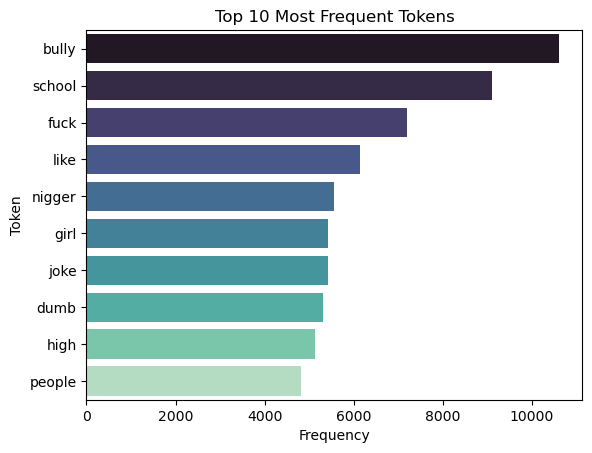

In [24]:
# Convert token frequencies into a DataFrame
token_df = pd.DataFrame(token_counts, columns=['Token', 'Frequency'])

# Token frequency bar chart
sns.barplot(y=token_df['Token'], x=token_df['Frequency'], palette='mako')
plt.title("Top 10 Most Frequent Tokens")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.show()

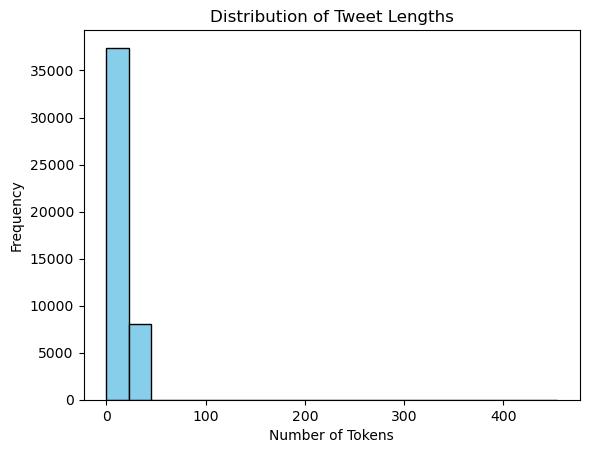

In [25]:
# Compute tweet lengths
df['tweet_length'] = df['processed_tokens'].apply(len)

# Plot histogram of tweet lengths
plt.hist(df['tweet_length'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

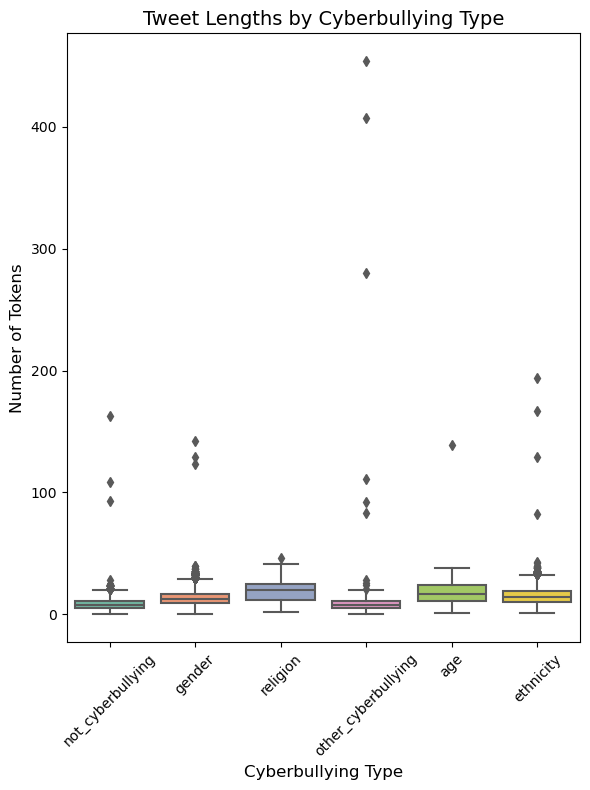

In [26]:
# Compare tweet lengths across different cyberbullying_type categories
# Boxplot of tweet lengths by cyberbullying type
plt.figure(figsize=(6, 8))
sns.boxplot(x='cyberbullying_type', y='tweet_length', data=df, palette='Set2')
plt.title("Tweet Lengths by Cyberbullying Type", fontsize=14)
plt.xlabel("Cyberbullying Type", fontsize=12)
plt.ylabel("Number of Tokens", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # Ensures everything fits within the figure
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

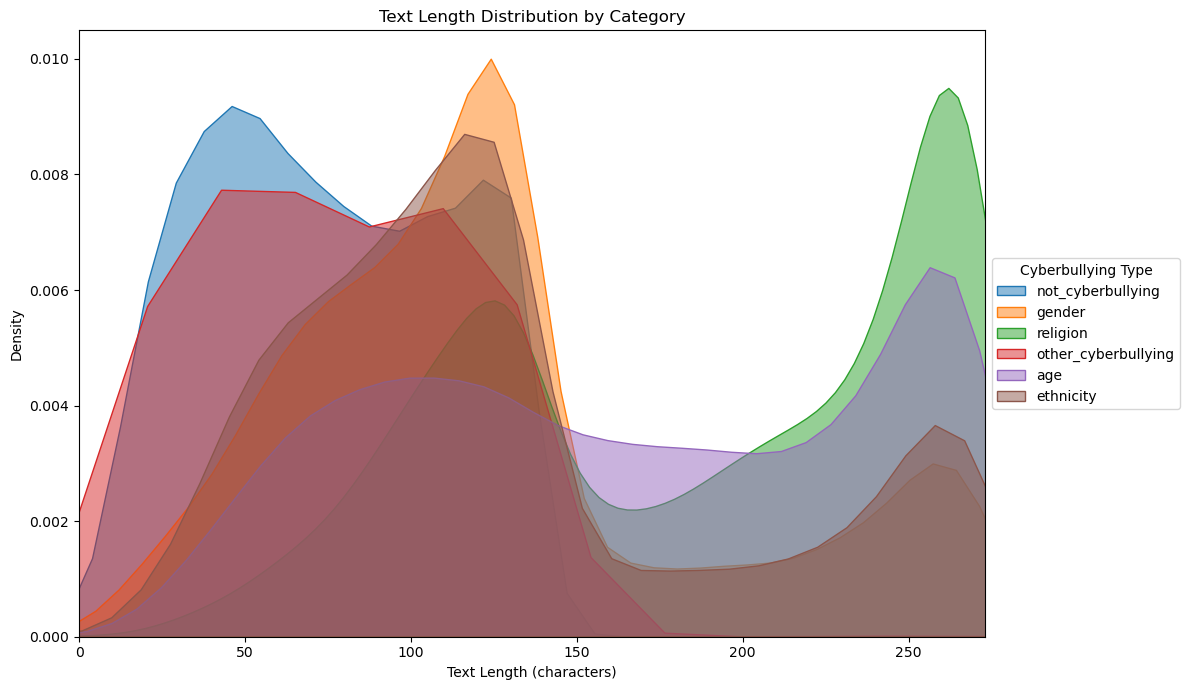

In [27]:
df['text_length'] = df['cleaned_text'].str.len()

# Text length distribution by category
labels = df['cyberbullying_type'].unique()

plt.figure(figsize=(12, 7))
for label in labels:
    subset = df[df['cyberbullying_type'] == label]
    sns.kdeplot(
        data=subset,
        x='text_length',
        label=label,
        fill=True,
        alpha=0.5
    )

plt.title('Text Length Distribution by Category', fontsize=12)
plt.xlabel('Text Length (characters)')
plt.ylabel('Density')
plt.xlim(0, df['text_length'].quantile(0.99))

plt.legend(title='Cyberbullying Type',
          title_fontsize=10,
          loc='center left',
          bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


Top words in not_cyberbullying:
   word  count
0   the   2646
1    to   2250
2     a   1930
3   mkr   1594
4   and   1493
5    is   1318
6   you   1281
7    of   1260
8    in   1064
9  that   1045


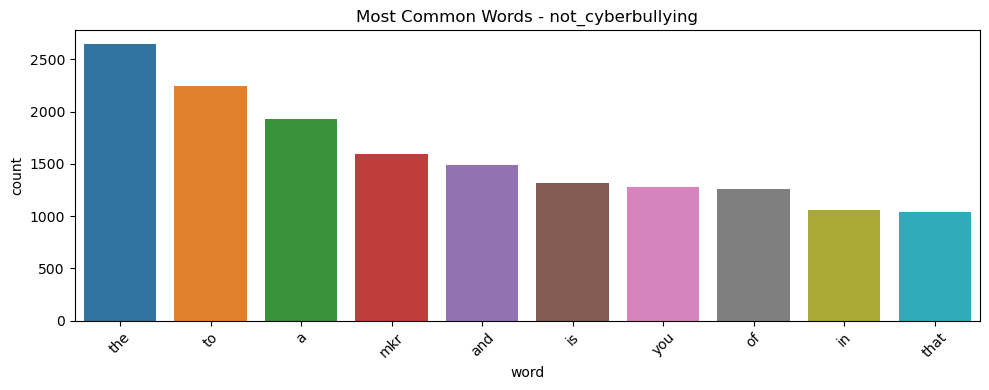


Top words in gender:
    word  count
0      a   5319
1    the   4151
2   rape   3976
3    and   3790
4    gay   3563
5  jokes   3372
6     to   3277
7     is   2431
8    you   2282
9     of   2155


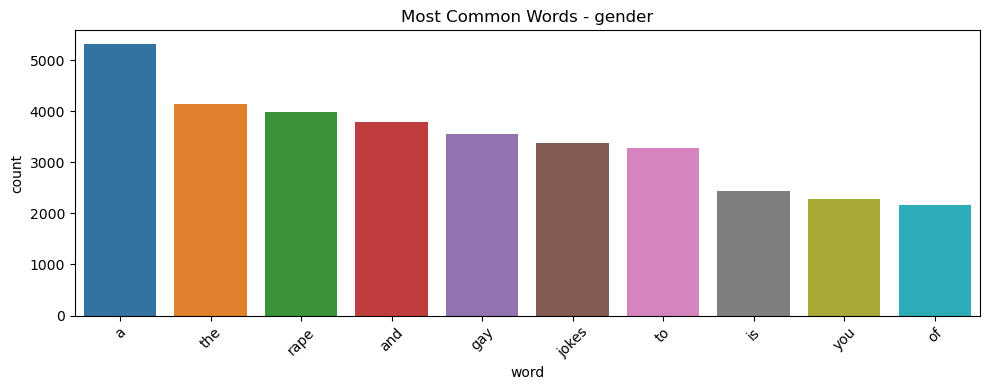


Top words in religion:
   word  count
0   the   8138
1   you   6435
2    to   5983
3   and   5734
4     a   5081
5    of   4872
6    is   4386
7   are   3525
8    in   3525
9  that   2683


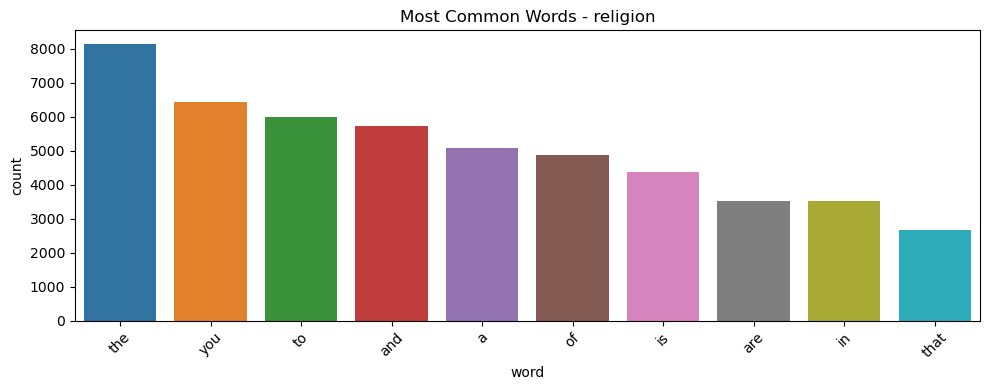


Top words in other_cyberbullying:
   word  count
0    to   2020
1     a   1955
2   the   1884
3    is   1230
4   you   1193
5    of   1101
6   and   1034
7  that    994
8    it    798
9  this    778


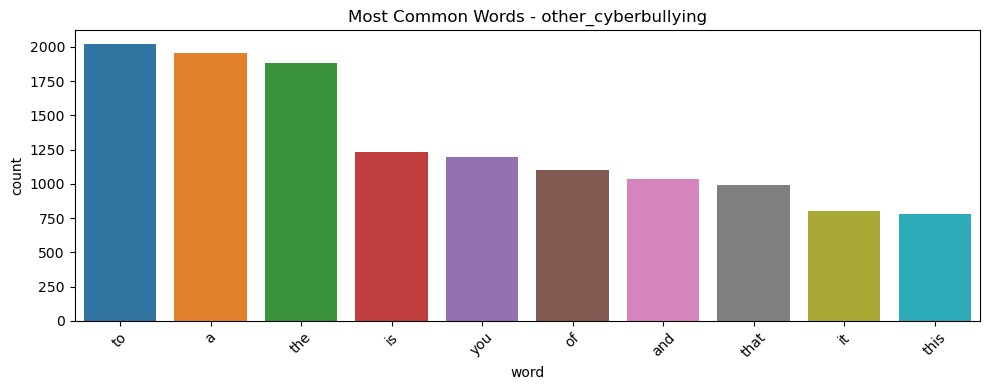


Top words in age:
      word  count
0   school   8113
1      the   7931
2       in   6092
3      and   6084
4       to   6012
5        a   5864
6     high   4896
7  bullied   4349
8       me   3894
9       of   3557


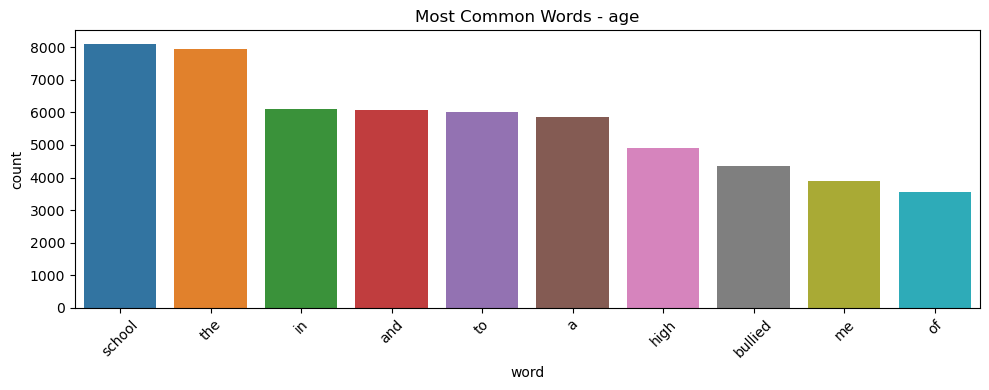


Top words in ethnicity:
     word  count
0     the   5500
1    dumb   5132
2    fuck   5117
3     you   4428
4  nigger   4293
5       a   4048
6      to   3311
7     and   3114
8      is   2261
9     ass   2244


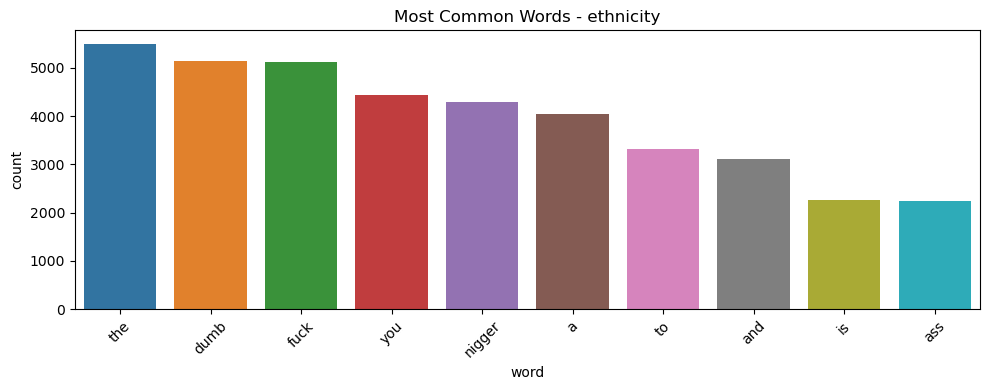

In [28]:
# Common words in each category
def get_top_words(group, n=10):
    words = ' '.join(group['cleaned_text']).split()
    return pd.DataFrame(Counter(words).most_common(n), columns=['word', 'count'])

for category in df['cyberbullying_type'].unique():
    print(f"\nTop words in {category}:")
    top_words = get_top_words(df[df['cyberbullying_type'] == category])
    print(top_words)

    plt.figure(figsize=(10, 4))
    sns.barplot(data=top_words, x='word', y='count')
    plt.title(f'Most Common Words - {category}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

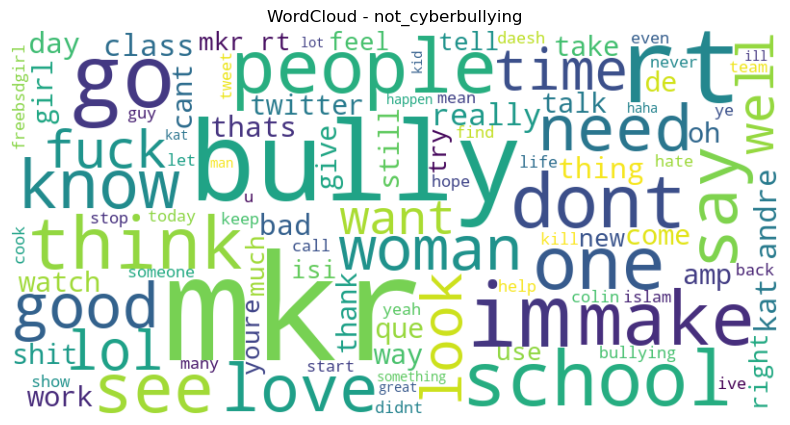

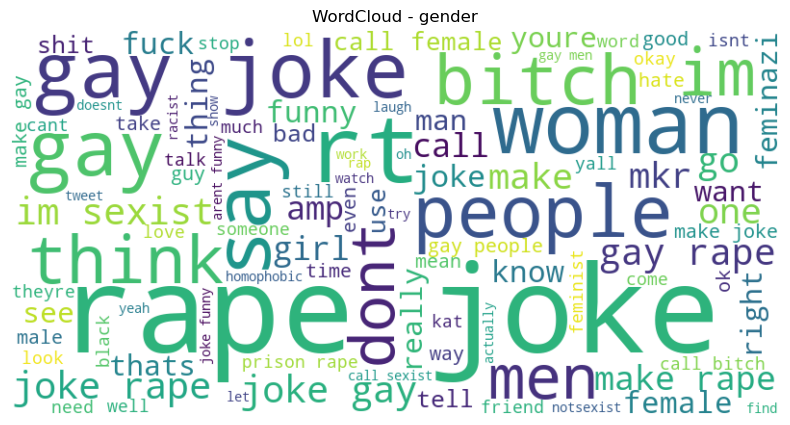

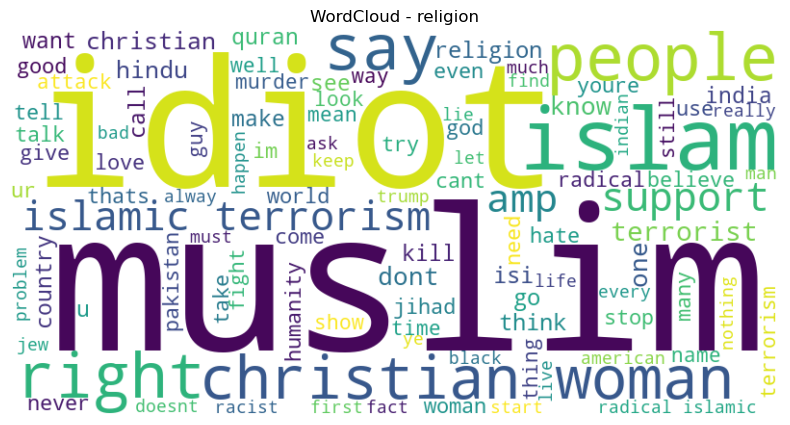

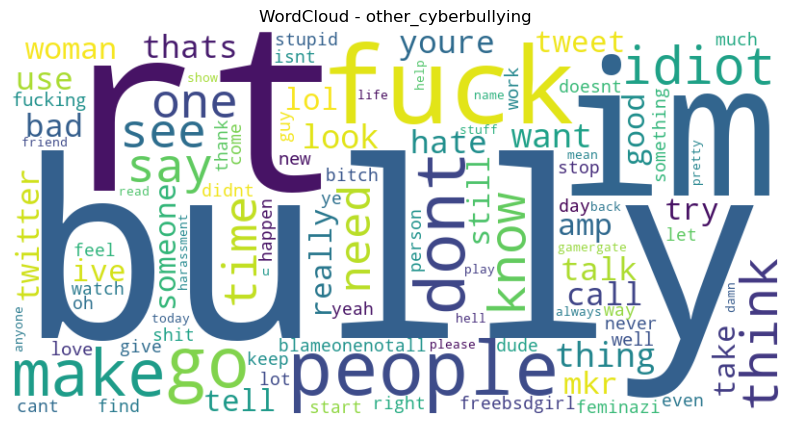

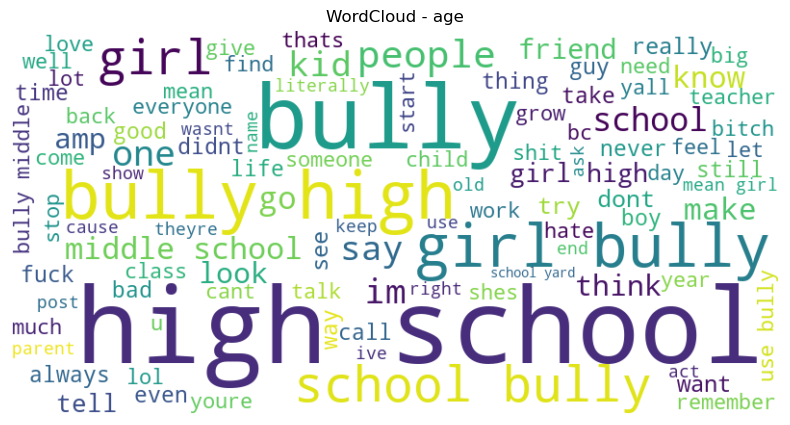

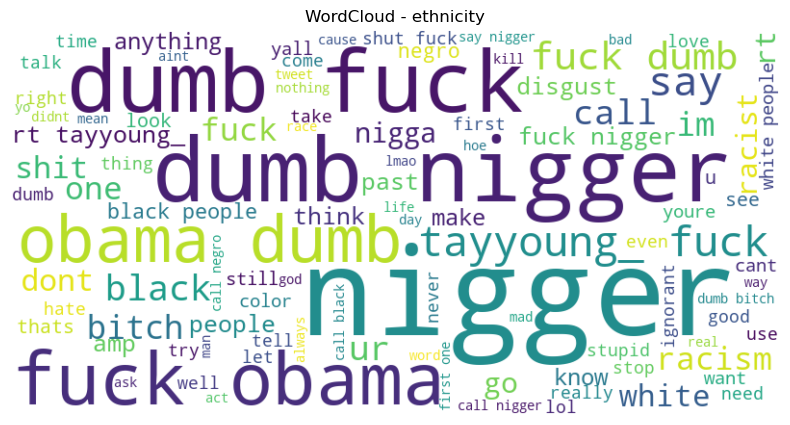

In [29]:
from wordcloud import WordCloud

def generate_wordcloud(tokens, title):
    # join tokens into space-separated string
    text = ' '.join([' '.join(tweet_tokens) for tweet_tokens in tokens])

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# make wordcloud for each category
for category in df['cyberbullying_type'].unique():
    subset = df[df['cyberbullying_type'] == category]
    generate_wordcloud(subset['processed_tokens'], f'WordCloud - {category}')

## 5) Feature Engineering: TF-IDF Vectorization

Before we train the model, we use TF-IDF for vectorization. This is necessary because ML models can't process raw text - they need numerical input. Vectorization converts text documents into numerical vectors that capture the frequency and importance of words.

Here, TF-IDF vectorization converts text into numerical vectors by:

* Creating vocabulary from unique words
* Calculating importance scores based on word frequency in document (TF) and rarity across documents (IDF)
* Representing each text as vector of these scores
* Common words get lower scores, distinctive words get higher scores



In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# prepare data
X = df['processed_tokens'].apply(' '.join)
y = df['cyberbullying_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [69]:
X_train

42872    think disgust black treat go call black man ho...
38441    awake think bitch qual method course somehow m...
28908    see bestfriend maybe 5 time month thats really...
27037    katexweis im black milk f21 basic old navy amp...
9663     rt peggy_olrenshaw ghostbusters 3 female lead ...
                               ...                        
11444    word former contestant whatsnextjake katie nik...
46899    one mad whats disgust white woman try breed bl...
40286    call bassboy garden boy house negro white zomb...
862                               congrats ash amp camilla
16134    evidence muslim groom gang prey majority white...
Name: processed_tokens, Length: 36412, dtype: object

In [71]:
X_test

30692    qampa u keynote speaker get hijack show harass...
13380    three gay romance trope hate theyre 1 cheat wi...
11650    could never insecure female last relationship ...
34840    bully girl everyday school 2nd grade throw hig...
30310    charlesrandall give ted talk one goal forever ...
                               ...                        
34010    omg cant even begin imagine poor child feel co...
25379    lol dude mention defend software piracy say do...
42490    stxrryxjoong hello pleeeease light one mutuals...
40836    karlakta hahahahahahaha yeah omg im dumb wtvr ...
7754     shoutout back gamergate think fork ggautoblock...
Name: processed_tokens, Length: 9104, dtype: object

## 6) Modeling

**A. Naive-Bayes**

Now we train a Naive Bayes classifier on the above vectorized text to predict cyberbullying types. The
performance is evaluated using classification report and a confusion matrix to visualize prediction accuracy and error patterns.

Classification Report:
                     precision    recall  f1-score   support

                age       0.62      0.99      0.76      1542
          ethnicity       0.83      0.90      0.87      1608
             gender       0.82      0.86      0.84      1513
  not_cyberbullying       0.70      0.40      0.51      1622
other_cyberbullying       0.67      0.21      0.32      1253
           religion       0.75      0.97      0.85      1566

           accuracy                           0.74      9104
          macro avg       0.73      0.72      0.69      9104
       weighted avg       0.74      0.74      0.70      9104



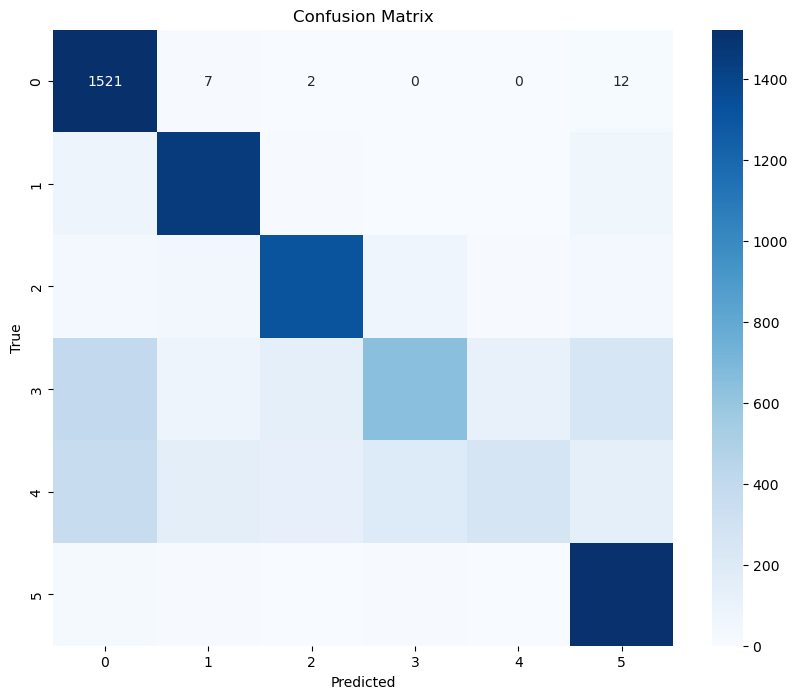

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# train and predict
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

# classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# visualize results
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Results:** The Naive Bayes model shows mixed performance across cyberbullying categories:

Strengths:
* High recall for age (0.99) and religion (0.97) categories
* Good overall accuracy (0.74)
* Strong F1-scores for ethnicity (0.87), religion (0.85), and gender (0.84)

Weaknesses:
* Poor performance on other_cyberbullying (F1=0.32) and not_cyberbullying (F1=0.51)
Confusion matrix shows significant misclassification between these categories

The model is better at identifying specific types of cyberbullying (age, religion, ethnicity, gender) than distinguishing between non-bullying and general bullying content.

**B. Support Vector Machine**

Similar Naive-Bayes Classifier training, the SVM model will be trained on vectorized text to predict cyberbullying types. The
performance is evaluated using classification report and a confusion matrix to visualize prediction accuracy and error patterns.

1. First we need to find the best hyperparameters using grid search

In [85]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Utilizing GridSearchCV to find best parameters of SVM
parameters = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
best_param = GridSearchCV(SVC(), parameters, cv=5)
best_param.fit(X_train_tfidf, y_train)

# Retrieve best combination of parameters 
result = best_param.best_params_
print(result)

{'C': 1, 'kernel': 'linear'}


2. Then the SVM model is trained

Classification Report
                     precision    recall  f1-score   support

                age       0.93      0.98      0.95      1542
          ethnicity       0.97      0.98      0.98      1608
             gender       0.91      0.86      0.89      1513
  not_cyberbullying       0.64      0.66      0.65      1622
other_cyberbullying       0.62      0.59      0.61      1253
           religion       0.95      0.96      0.95      1566

           accuracy                           0.85      9104
          macro avg       0.84      0.84      0.84      9104
       weighted avg       0.84      0.85      0.84      9104



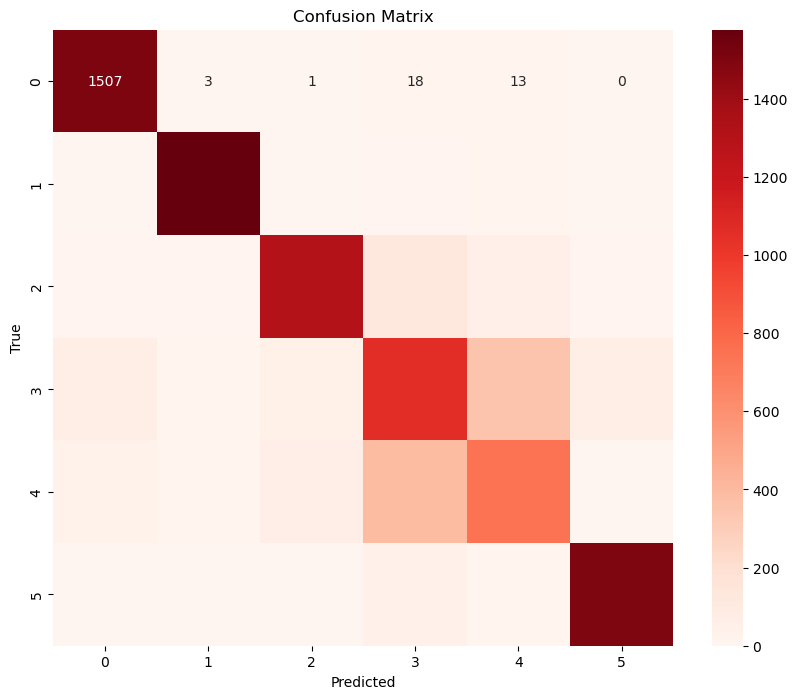

In [86]:
# Train and predict
model = SVC(**result)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

# Classification report
print("Classification Report")
print(classification_report(y_test, y_pred))

# Visualize results
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
**Results:** The SVM model also shows mixed performance across cyberbullying categories:

Strengths:
* High recall for age (0.98), ethnicity (0.98), and religion (0.96) categories
* Good overall accuracy (0.85) meaning that the model correctly classifies 85% of the samples
* Strong F1-scores for age(0.95), ethnicity (0.98), religion (0.95), and gender (0.89)

Weaknesses:
* Poor performance on other_cyberbullying (F1=0.61) and not_cyberbullying (F1=0.65)
Confusion matrix shows significant misclassification between these categories

The model is better at identifying specific types of cyberbullying (age, religion, ethnicity, gender) than distinguishing between non-bullying and general bullying content.

## 7) Model Evaluation
Compare models using evaluation metrics like:
Accuracy.
Precision, Recall, and F1-Score.
Confusion matrix for deeper insights.

## 8) Stretch Goals (Optional)
can cross-compare it with our base model

- Sentiment Analysis: Pre-trained sentiment analysis - models (e.g., using TextBlob or VADER) can be applied to processed_text.
    - Compare the effectiveness of sentiment-only features against other feature engineering methods (e.g., Bag-of-Words or embeddings).
    - Test if sentiment adds value to the regular model's performance.
- Intent Detection: Use embeddings or transformer models for intent classification (if time allows).